### Imports and helpers

In [28]:
import sys
sys.path.append('..')

In [29]:
import numpy as np
import torch
import torchvision
from torchvision import transforms as pth_transforms
from statistics_incontext_learning_utils import *

### Models list

In [30]:
stats_dict = {
    'random':{'pretrained_weights':'random'},
    'stylegan':{'pretrained_weights':'../dino/encoders/stylegan-oriented-512/checkpoint.pth'},
    'shaders':{'pretrained_weights':f'../dino/encoders/shaders/checkpoint.pth'},
    'shaders_mixup':{'pretrained_weights':f'../dino/encoders/shaders_mixup/checkpoint.pth'},
    "shaders_kml":{'pretrained_weights':f'../dino/encoders/shaders_kml/checkpoint.pth'},
    "shaders_kml_mixup":{'pretrained_weights':f'../dino/encoders/shaders_kml_mixup/checkpoint.pth'},
    'places':{'pretrained_weights':f'../dino/encoders/imagenet/checkpoint.pth'},
    'imagenet':{'pretrained_weights':f'../dino/encoders/imagenet/checkpoint.pth'},
}

In [31]:
# model = load_model(stats_dict['random']['pretrained_weights'])
# model = load_model(stats_dict['stylegan']['pretrained_weights'])
# model = load_model(stats_dict['shaders']['pretrained_weights'])
## model = load_model(stats_dict['shaders_mixup']['pretrained_weights'])
# model = load_model(stats_dict['shaders_kml']['pretrained_weights'])
model = load_model(stats_dict['shaders_kml_mixup']['pretrained_weights'])
# model = load_model(stats_dict['places']['pretrained_weights'])
# model = load_model(stats_dict['imagenet']['pretrained_weights'])

/vision-nfs/torralba/projects/adrianr/procedural_datasets/full_visual_memory/notebooks_figures/statistics_incontext_learning_utils.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental

### Load ADE

In [32]:
def get_instance_mask(ade_img, id):
  print(np.unique(ade_img['objects']['class']))
  masks = [torch.from_numpy(ade_img['instance_mask'] == i+1).float() for i, label in enumerate(ade_img['objects']['class']) if label == id]
  return torch.stack(masks).sum(0)

In [33]:
def get_class_mask(ade_img, id):
  print(np.unique(ade_img['class_mask']))
  return torch.from_numpy(ade_img['class_mask'] == id).float()[None, :, :]

In [34]:
get_instance_idx = lambda x, idx: (x['img'], get_instance_mask(x, idx))

In [35]:
get_segmentation_person = lambda x: (x['img'], get_class_mask(x, 1831))
get_segmentation_floor = lambda x: (x['img'], get_class_mask(x, 838))
get_segmentation_idx = lambda x, idx: (x['img'], get_class_mask(x, idx))

In [36]:
import cv2
from PIL import Image, ImageDraw
import numpy as np

def add_circle(x, y):
  mass_x, mass_y = np.where(y >= 0.5)
  cent_x = np.average(mass_x)
  cent_y = np.average(mass_y)
  radius = 0.025 * min(x.width, x.height)

  # print(type(x))
  # x = cv2.circle(x,(cent_x, cent_y), radius, (255,0,0), -1)
  # x[cent_x-radius:cent_x+radius, cent_y-radius:cent_y+radius, :] = np.array([255, 0, 0])
  draw = ImageDraw.Draw(x)
  draw.ellipse((cent_y - radius, cent_x - radius, cent_y + radius, cent_x + radius), fill = 'red', outline ='red')

  return x, y

def add_line(x, y):
  mass_y, mass_x = np.where(y >= 0.5)
  cent_x = np.average(mass_x)
  cent_y = np.average(mass_y)
  radius = 0.0125 * min(x.width, x.height)

  # print(type(x))
  # x = cv2.circle(x,(cent_x, cent_y), radius, (255,0,0), -1)
  # x[cent_x-radius:cent_x+radius, cent_y-radius:cent_y+radius, :] = np.array([255, 0, 0])
  draw = ImageDraw.Draw(x)
  # draw.line((min(mass_y), cent_x, min(mass_y), cent_x), fill = 'red', width = 10)
  line_coords = (int(cent_x), mass_y[mass_x == int(cent_x)].min(), int(cent_x), mass_y[mass_x == int(cent_x)].max())
  color = tuple(np.random.default_rng(0).integers(0, 255, 3))
  draw.line(line_coords, fill = color, width = int(radius*2))

  return x, y

In [37]:
def transform_ade(img):
  # x, y = get_segmentation_person(img)
  x, y = get_segmentation_idx(img, 1831) # person
  # x, y = get_segmentation_idx(img, 838) # ground / grass
  # x, y = get_segmentation_idx(img, 103) # 
  # x, y = get_instance_idx(img, 'ground')
  # x, y = add_circle(x, y)
  # x, y = add_line(x, y)
  return x, y

In [38]:
from ade20k.ade_utils import ADEDataset

ade_ds = ADEDataset('../data/ade20k/paths.json', transform=transform_ade)

### Prepare images

[   0  103  838  907 1831]
819 1024


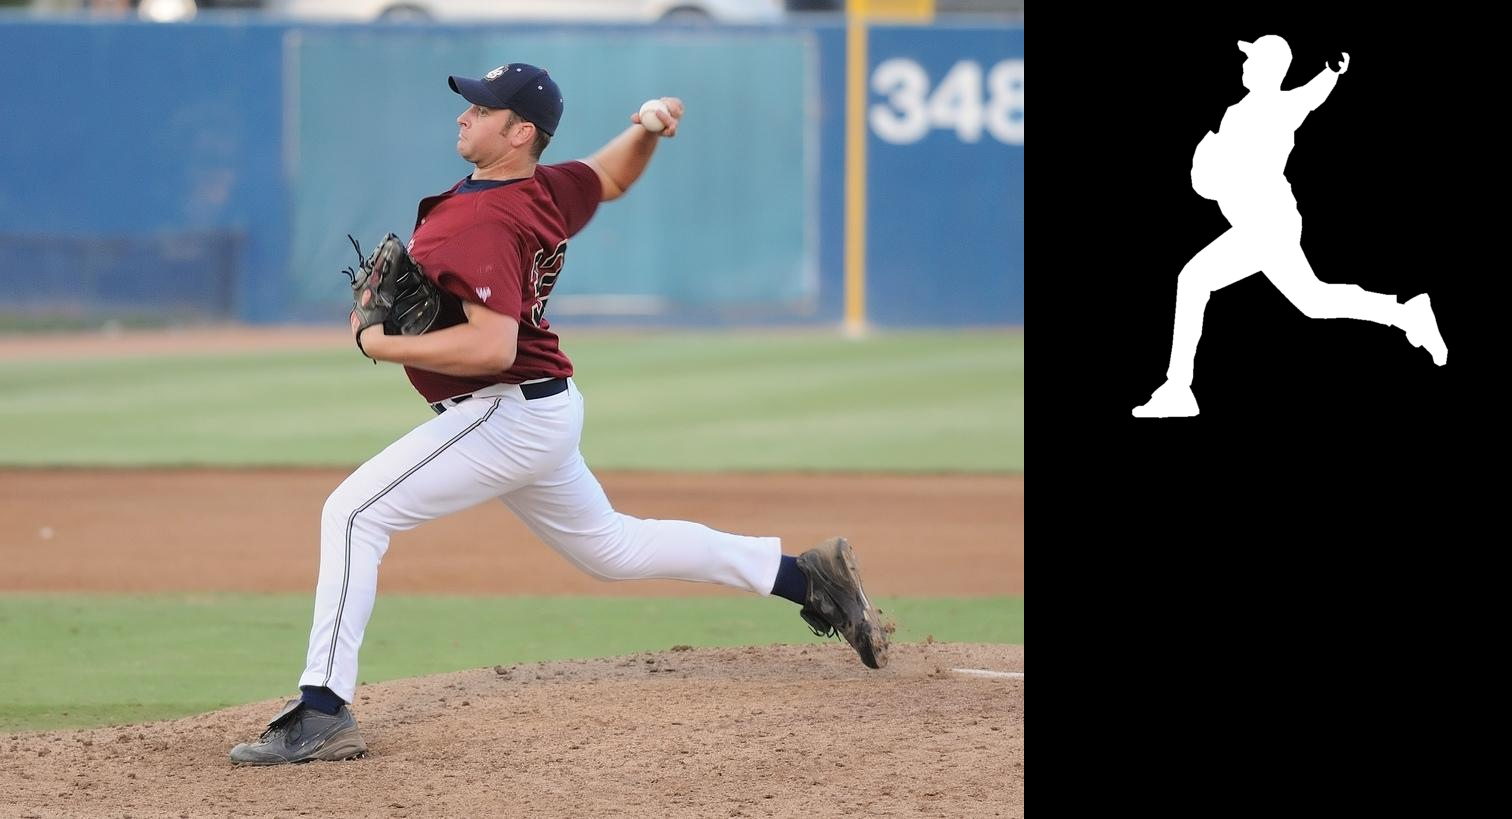

In [41]:
## Baseball players
# x1, y1 = ade_ds[9554]
# x1, y1  = ade_ds[9555]
# x1, y1 = ade_ds[9556]
# x1, y1 = ade_ds[9558]
x1, y1 = ade_ds[9559] # baseball x1
# x1, y1 = ade_ds[9560]
# x1, y1 = ade_ds[9561]
# x1, y1 = ade_ds[9562] # child, yellow

## Lab
# x1, y1 = ade_ds[956] # wrongly labeled
# x1, y1 = ade_ds[1001]
# x1, y1 = ade_ds[1002] # scientist x1
# x1, y1 = ade_ds[1004]
# x1, y1 = ade_ds[1005]

## Home
# x1, y1 = ade_ds[4660]
# x1, y1 = ade_ds[4679]
# x1, y1 = ade_ds[4914]
# x1, y1 = ade_ds[4942]
# x1, y1 = ade_ds[5030]
# x1, y1 = ade_ds[5076]
# x1, y1 = ade_ds[5122]

## Batting cage
# x1, y1 = ade_ds[9679]
# x1, y1 = ade_ds[9681]
# x1, y1 = ade_ds[9682]
# x1, y1 = ade_ds[9683]
# x1, y1 = ade_ds[9685]

## House
# x1, y1 = ade_ds[9686]

## Volleyball court
# x1, y1 = ade_ds[9676]

## Basketball court
# x1, y1 = ade_ds[9677]


print(x1.height, x1.width)
plot_image_and_seg(x1, y1)

[   0  838  907 1100 1831 2855]
669 1000


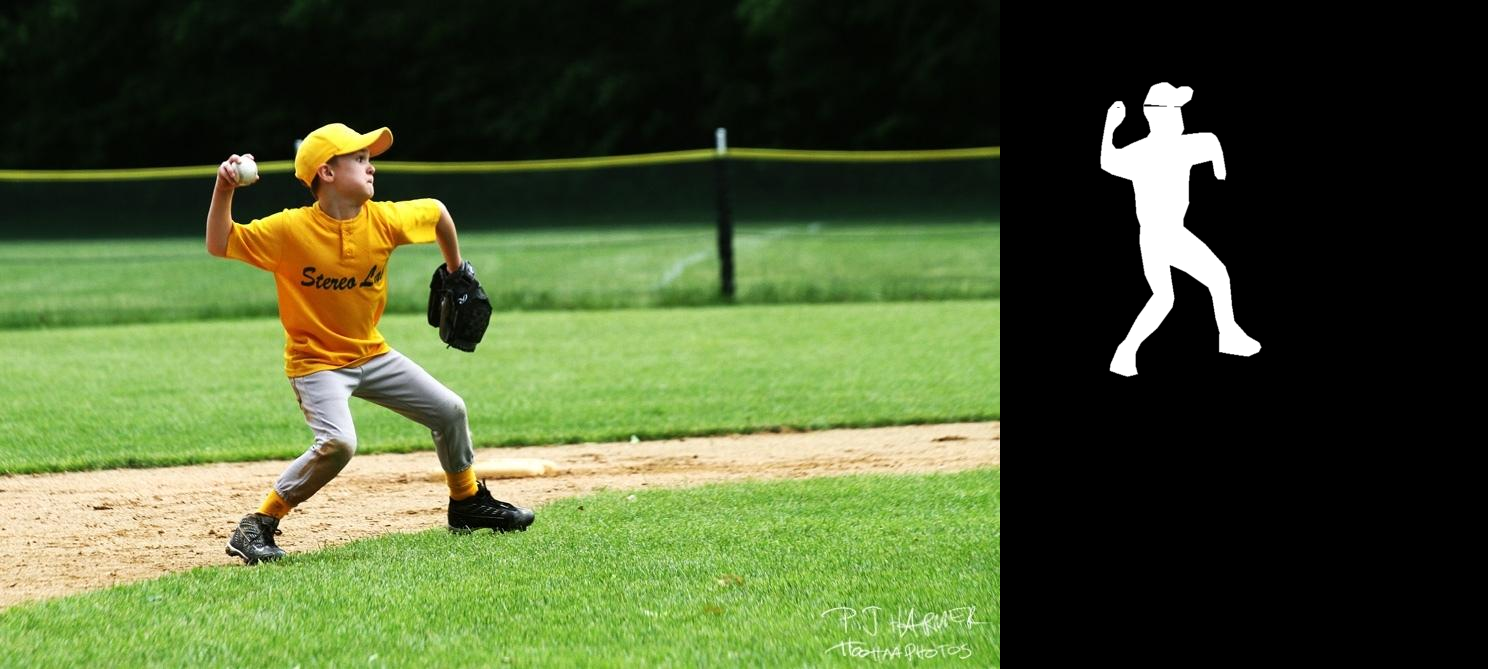

In [42]:
## Baseball players
# x2, y2 = ade_ds[9554]
# x2, y2  = ade_ds[9555]
# x2, y2 = ade_ds[9556]
# x2, y2 = ade_ds[9558]
# x2, y2 = ade_ds[9559]
# x2, y2 = ade_ds[9560]
# x2, y2 = ade_ds[9561]
x2, y2 = ade_ds[9562] # child, yellow, good with 9559

## Lab
# x2, y2 = ade_ds[956] # scientist x2 wrongly labeled
# x2, y2 = ade_ds[1001]
# x2, y2 = ade_ds[1002]
# x2, y2 = ade_ds[1004]
# x2, y2 = ade_ds[1005]

## Home
# x2, y2 = ade_ds[4660]
# x2, y2 = ade_ds[4679]
# x2, y2 = ade_ds[4914]
# x2, y2 = ade_ds[4942]
# x2, y2 = ade_ds[5030]
# x2, y2 = ade_ds[5076]
# x2, y2 = ade_ds[5122]

## Batting cage
# x2, y2 = ade_ds[9679]
# x2, y2 = ade_ds[9681]
# x2, y2 = ade_ds[9682]
# x2, y2 = ade_ds[9683]
# x2, y2 = ade_ds[9685]

## House
# x2, y2 = ade_ds[9686]

## Volleyball court
# x2, y2 = ade_ds[9676]

## Basketball court
# x2, y2 = ade_ds[9677]

## Bio lab
# x2, y2 = ade_ds[956]

print(x2.height, x2.width)
plot_image_and_seg(x2, y2)

### In-context algorithms

In [43]:
def image_to_patches(x, smaller_edge_size: float = 448, patch_size: int = 14):
    transforms_list =  [
        pth_transforms.Resize(size=smaller_edge_size, interpolation=pth_transforms.InterpolationMode.BICUBIC, antialias=True),
    ]
    if not isinstance(x, torch.Tensor):
        transforms_list.append(pth_transforms.ToTensor())
    transform = pth_transforms.Compose(transforms_list)

    # Resize and transform
    image_tensor = transform(x)    

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w (TODO: check)

    # Get patches
    # patches = image_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    unfold_fn = torch.nn.Unfold(kernel_size=(patch_size, patch_size), stride=(patch_size, patch_size))
    patches = unfold_fn(image_tensor)

    return patches, image_tensor.shape

def patches_to_image(x, output_size, patch_size=14):
   fold_fn = torch.nn.Fold(output_size=output_size, kernel_size=(patch_size, patch_size), stride=(patch_size, patch_size))
   return fold_fn(x)

In [44]:
y1_patches, cropped_shape = image_to_patches(y1)
print(y1_patches.shape)
y1_recon = patches_to_image(y1_patches, cropped_shape[1:])
print(y1.shape, y1_recon.shape)

torch.Size([196, 1280])
torch.Size([1, 819, 1024]) torch.Size([1, 448, 560])


In [45]:
def resize_transform(smaller_edge_size: int = 448) -> pth_transforms.Compose:
    interpolation_mode = pth_transforms.InterpolationMode.BICUBIC

    return pth_transforms.Compose([
        pth_transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        pth_transforms.ToTensor(),
    ])

def incontext_cross_attention_fullres(model, x1, y1, x2):
  smaller_edge_size = 448
  patch_size = model.patch_size

  # Calculate features
  z1 = render_features(model, x1, smaller_edge_size=smaller_edge_size, patch_size=patch_size)
  z2 = render_features(model, x2, smaller_edge_size=smaller_edge_size, patch_size=patch_size)
  (h1, w1, C), (h2, w2, _) = z1.shape, z2.shape

  # Resize prompt answer
  # y1 = pth_transforms.Resize((h1, w1), interpolation=2)(y1.unsqueeze(0))[0]
  y1_patches, cropped_shape = image_to_patches(y1, smaller_edge_size=smaller_edge_size, patch_size=patch_size)
  print(y1_patches.shape)

  # Calculate cross attention
  # z1z2 = (z1[:, :, None, None, :] * z2[None, None, :, :, :]).sum(-1) / C**0.5
  z1z2 = (z1[:, :, None, None, :] * z2[None, None, :, :, :]).sum(-1) / C
  # z1z2 = (z1[:, :, None, None, :] * z2[None, None, :, :, :]).sum(-1) / C**2
  z1z2 = z1z2.view(-1, h2, w2).softmax(0).view(h1, w1, h2, w2)  

  # Compute answer
  f2 = (z1z2 * y1_patches.view(-1, h1, w1)[:, :, :, None, None]).sum((1, 2)).flatten(1)
  print(f2.shape)
  # print(f2.shape)
  _, cropped_shape = image_to_patches(x2, smaller_edge_size=smaller_edge_size, patch_size=patch_size)
  print(cropped_shape)
  f2 = patches_to_image(f2, cropped_shape[1:], patch_size=patch_size)
  f2 = pth_transforms.Resize((x2.height, x2.width), interpolation=pth_transforms.InterpolationMode.BILINEAR)(f2.unsqueeze(0))[0]

  return f2

### Visualization

In [46]:
from PIL import ImageFilter

In [47]:
def calc_iou(output, target):
  # return (f2 * y2).sum() / (f2 + y2 - f2*y2).sum()
  return np.minimum(output, target).sum() / np.maximum(output, target).sum()

In [48]:
def visualize_segmentation(model, incontext_f, x1, y1, x2, y2, th = 0.5):
  f2 = incontext_f(model, x1, y1, x2)
  y2 = y2[:, :f2.shape[1], :f2.shape[2]]

  f2_th = 1 / (1 - th) * torch.relu(f2 - th)
  # f2_th = (f2 > th+1e-6).float()

  # metrics
  iou = calc_iou(f2, y2)
  iou_th = calc_iou(f2_th, y2)
  print('iou', iou.item(), f'iou_th{th}', iou_th.item())

  if th != 0:
    display(plot_images([x1, y1, y1, y1]))
    display(plot_images([x2, y2, f2, f2_th]))
  else:
    display(plot_images([x1, y1, y1]))
    display(plot_images([x2, y2, f2]))

torch.Size([256, 980])
torch.Size([256, 1148])
torch.Size([3, 448, 656])
iou 0.24070340394973755 iou_th0.2 0.2199622094631195


/tmp/ipykernel_3260981/4118504014.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.minimum(output, target).sum() / np.maximum(output, target).sum()


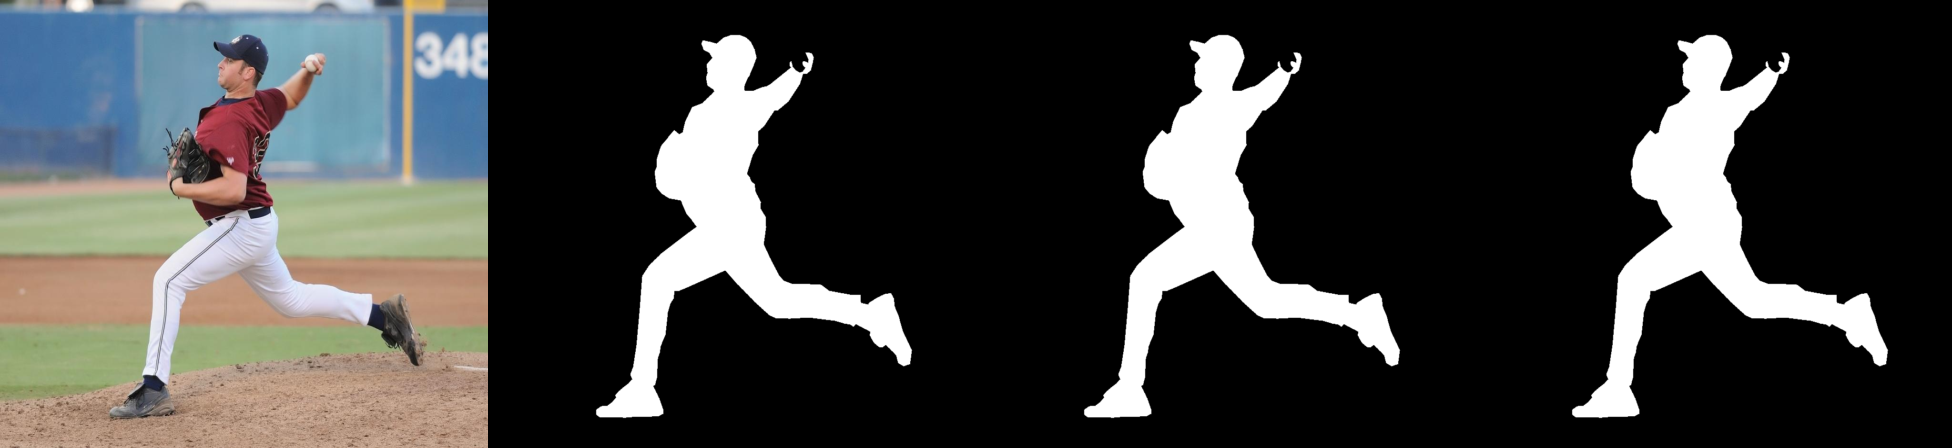

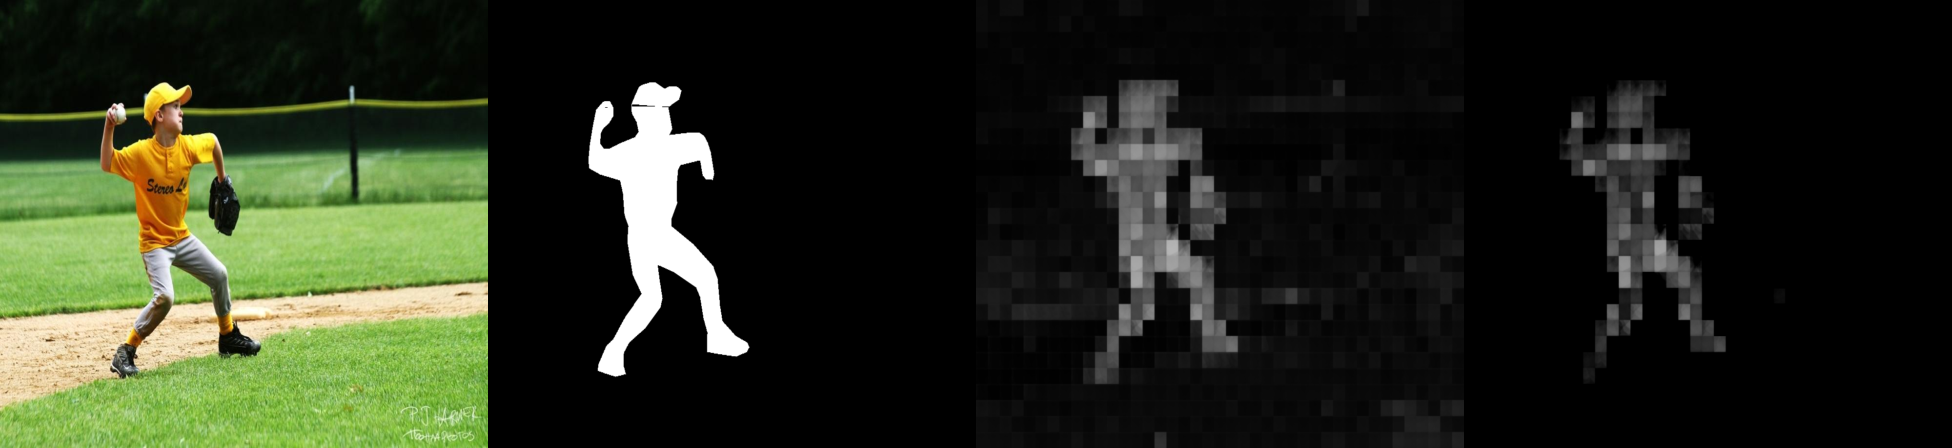

In [49]:
visualize_segmentation(model, incontext_cross_attention_fullres, x1, y1, x2, y2, th = 0.2)